# FAB-COST

The cells found below contain the code for the inference procedure used in the FAB-COST contextual bandit algorithm (ref?). FAB-COST's inference procedure is benchmarked against the frequesntly used Laplace approximation. We also approximate the posterior distribution with the NUTS MCMC sampler which we assume represents the ground truth. 


In [1]:
# import required libraries 

%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib 

import pylab
from random import randint
import matplotlib.patches as mpatches
import scipy as sp
from scipy import linalg
import sklearn

import seaborn as sns
import matplotlib.mlab as mlab

def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    if(sig < 0.000001):
        sig = 0.000001
    return sig

def d_sigmoid(x):
    return np.exp(-x) / ((1 + np.exp(-x))*(1 + np.exp(-x)))   

### Data
Firstly, data must be fed into the algorithm in the form of a co-occurrence matrix $\mathbf{X} \in \mathbb{R}^{T \times K}$ (the input) and the binary vector $\mathbf{y} \in \mathbb{R}^T$ (the output). 
This can either be data fed in or simulated data. Due to UK data sensitivity laws, the Auto Trader dataset used in (ref?) cannot be uploaded here but a simulated dataset is used to show 

In [2]:
# simulated data in a single batch

d = 6 # number of covariates
H = np.ones(d)*(1/10**2) # vector of prcision values
H = np.diag((H)) # initialises Hessian as identity
wprior = np.zeros((d)) # initialises prior vector
w = np.zeros((d)) # initialises weight vector
n = 500000 # number of samples
X = np.ones((n,d))
seed = 123 # use seed if needed 
np.random.seed(seed)
for i in range(1,d): # random design matrix
    X[:,i] = np.random.rand(n)

beta = [1.0, 0.2, 1.5, -1.0, -0.7, -0.2] # weights 
z = beta[0]*X[:,0] + beta[1]*X[:,1] + beta[2]*X[:,2] + beta[3]*X[:,3] + beta[4]*X[:,4] + beta[5]*X[:,5] # linear combination of weights and covariates

pr = 1/(1 + np.exp(-z)) # logistic activation function
y = np.ones((n,1)) # initialise 
y = np.random.binomial(1,pr) # generate simulated observations from binomial distribution
y2 = y*2-1 # for EP and ADF calculations we require y = {-1,+1}

### Breakpoints

Break points must be defined. This is the point at which the posterior approximations will be plotted.
`n_first` is the point at which ADF takes over EP in the FAB-COST algorithm 

In [3]:
n_first = 10000 # size of first batch (and when ADF takes over EP)
n_second = 50000 # size of second batch
n_third = 200000 # size of third batch
n_fourth = X.shape[0] # size of fourth batch

### PYMC3 
PyMC3 is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning https://pymc3.readthedocs.io/en/latest/#.

This is used to run the No-U-Turn Sampler on the dataset. 

Ensure that PYMC3 is installed before running; this can be done by a quick `pip install pymc3`

In [4]:
import pymc3 as pm
import theano.tensor as t
from scipy.stats import mode

with pm.Model() as logistic_model:
    # Define priors
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = d)
       
    logit_p = t.dot(X[0:n_first,:], beta)
    pm.Bernoulli('likelihood', logit_p=logit_p, observed=y[0:n_first])
    
with logistic_model:
    # Inference
    trace = pm.sample(4000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 18000/18000 [01:29<00:00, 201.68draws/s]
The acceptance probability does not match the target. It is 0.8857158751262241, but should be close to 0.8. Try to increase the number of tuning steps.


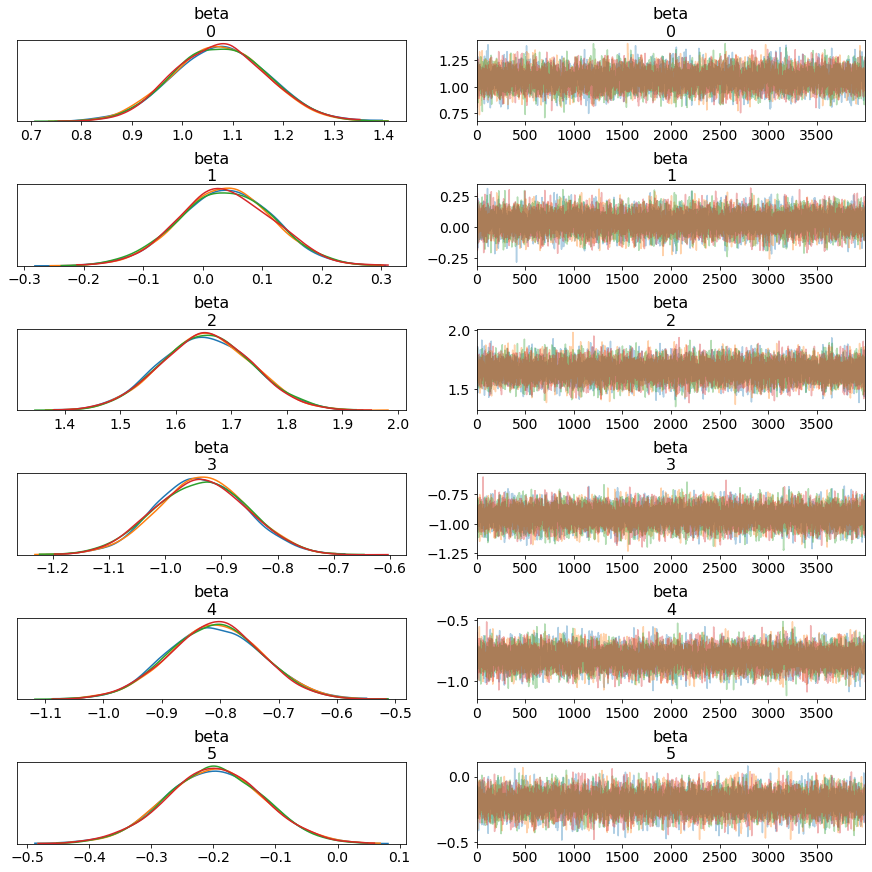

In [5]:
# PYMC3 posterior histograms for each weight
axes = pm.traceplot(trace)

### FAB-COST 
EP is used with the first batch to give an accurate prior for the ADF algortihm to use.
We must first initialise the moment parameters of all the local sites as well as the global approximation:

In [6]:
# EP initialisation

cycle = 4 # number of sweeps made through dataset
var = 100 # initial local variance
V_local = np.zeros((n_first,d,d)) # initialise tensor comprised of covariance matrix for each site of approximation
for i in range(0,n_first):
    V_local[i] = (var)*np.eye(d) # independent covariance matrix for each site
V_global = np.eye(d) # initialise covariance matrix for global approximation 
Vmi = np.ones((d,d)) # initialise V cavity
m_local = np.zeros((n_first,d)) # initialise matrix comprised of first moment vectors for each site of approximation 
m_global = np.zeros((d,1)) # m vector for global approximation
mmi = np.ones((d,1)) # initialise m cavity

Prec_ep = np.zeros((d,d))
for i in range(0,n_first):
    Prec_ep = Prec_ep + np.linalg.pinv(V_local[i])
V_global = np.linalg.pinv(Prec_ep) # calculates global varaiance (global precision = sum(local precisions))



In [7]:
# EP sweeps

pos = 0

for count in range(0,cycle): 
    for i in range(0,n_first):
        
        Vmi = np.linalg.pinv( np.linalg.pinv( V_global ) - np.linalg.pinv( V_local[i] )) # covariance cavity
        mmi = Vmi.dot((np.linalg.pinv( V_global ).dot(m_global) - np.linalg.pinv( V_local[i] ).dot(m_local[i][np.newaxis, :].T)))# mean cavity
        
        k = 1/np.sqrt(1+ ((np.pi/8)*np.inner(X[i,:].dot(Vmi),X[i,:]))) # Mackay's approximation constant
        zz = y2[i]*(np.transpose(X[i,:]).dot(mmi))*k
        Z = sigmoid(zz) # logistic function
        d_Z = d_sigmoid(zz) # derivative of logistic function
        
        alpha_ep = y2[i]*k*(d_sigmoid(zz)/sigmoid(zz))*(X[i,:][np.newaxis, :].T) # log-partition diff wrt mmi
        beta_ep = (-np.pi*k**2/16)*np.outer(X[i,:],X[i,:]).dot(np.outer(mmi,alpha_ep)) # log-partition diff wrt vmi
                             
        m_global = mmi + Vmi.dot(alpha_ep)# update of mean for approimating distribution q
        V_global = Vmi - Vmi.dot((np.outer(alpha_ep,alpha_ep) - 2*beta_ep)).dot(Vmi) # update of variance for approimating distribution q

        V_local[i] = np.linalg.pinv(np.linalg.pinv(V_global) - np.linalg.pinv(Vmi)) # update local site covariance
        m_local[i] = (V_local[i].dot( np.linalg.pinv(V_global).dot(m_global) - np.linalg.pinv(Vmi).dot(mmi) ))[:,np.newaxis].T # update local site mean
        

### The Laplace approximation.
The library taken from (ref) is used to make a Laplace approximation. This is found in the file `Laplace_approximation.ipynb`. Ensure that ipynb is installed; can be done by a quick `pip install ipynb`

In [8]:
from ipynb.fs.full.Laplace_approximation import * # imports defininitions needed from Laplace_approximation


H = np.ones(d)*(1/10**2) # initialises Hessian (precision matrix) as identity (for Laplace)
H = np.diag((H)) # initialises Hessian as identity (for Laplace)
wprior = np.zeros((d)) # initialises prior vector

w_laplace, H_laplace = fit_bayes_logistic(y[0:n_first], X[0:n_first,:], wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=1000)# Laplace inference


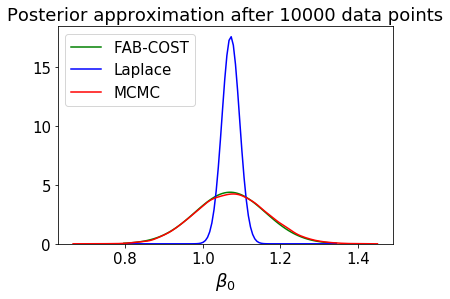

In [9]:
# posterior plot of beta_0
x = np.linspace(m_global[0] - 3*V_global[0,0]**0.5, m_global[0] + 3*V_global[0,0]**0.5, 100)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)
plt.xlabel(r'$\beta_0$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_first, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[0], V_global[0,0]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[0], 1/H_laplace[0,0]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,0], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()

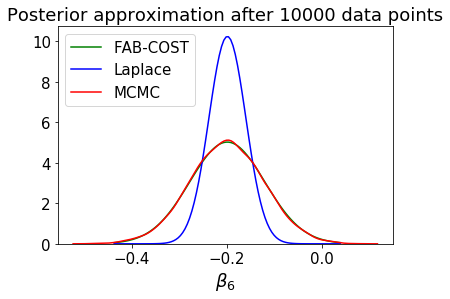

In [10]:
# posterior plot of beta_6
x = np.linspace(m_global[5] - 3*V_global[5,5]**0.5, m_global[5] + 3*V_global[5,5]**0.5, 100)
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=15) 
plt.xlabel(r'$\beta_6$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_first, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[5], V_global[5,5]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[5], 1/H_laplace[5,5]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,5], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()

Up to this point FAB-COST, Laplace and the MCMC have be used to approximated the posterior distribution upto `n_first`.
The notebook now repeats the previous steps for the remining breakpoints. FAB-COST uses the posterior calculated from EP as the prior for ADF and processes the remaining data set sequentially. 

In [11]:
# PYMC3
with pm.Model() as logistic_model:
    # Define priors
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = d)
       
    logit_p = t.dot(X[0:n_second,:], beta)
    pm.Bernoulli('likelihood', logit_p=logit_p, observed=y[0:n_second])
    
    
with logistic_model:
    # Inference
    trace = pm.sample(4000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 18000/18000 [05:44<00:00, 52.30draws/s]
The acceptance probability does not match the target. It is 0.8919875912839121, but should be close to 0.8. Try to increase the number of tuning steps.


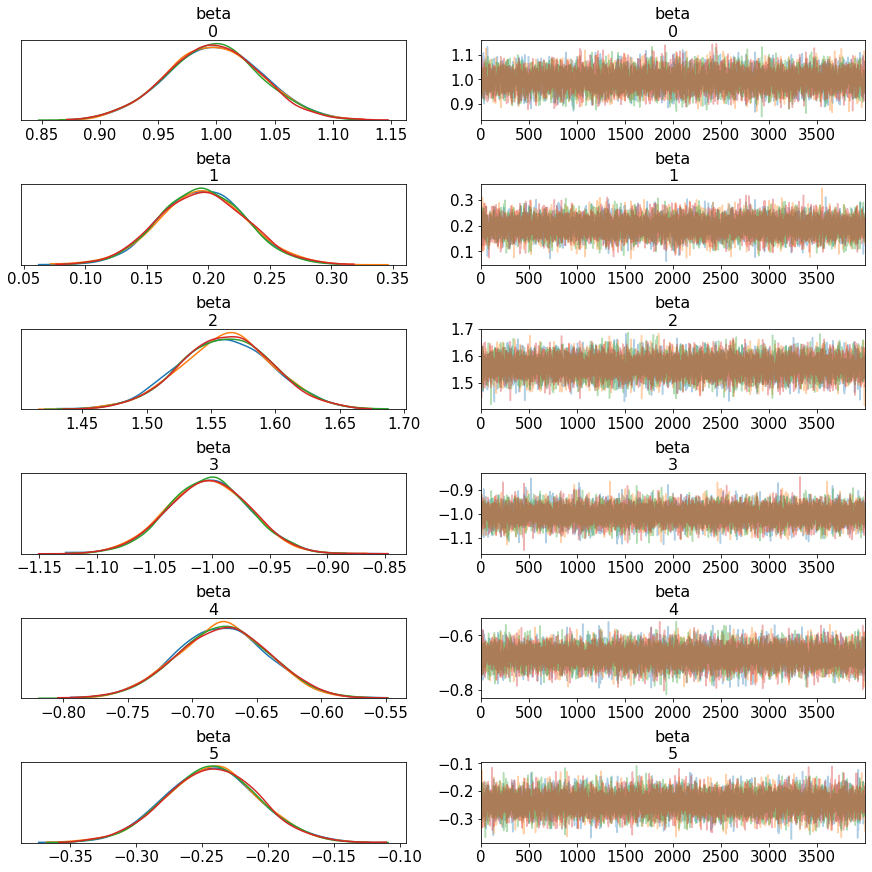

In [12]:
axes = pm.traceplot(trace)

In [13]:
# Assumed Density Filtering 

for i in range(n_first,n_second): # begins from where EP left off
    
    # for each iteration i, a cavity distribtuion is formed. 
    Vmi = V_global
    mmi = m_global
            
    k = 1/np.sqrt(1+ ((np.pi/8)*np.inner(X[i,:].dot(Vmi),X[i,:]))) # Mackay's approximation constant
    zz = y2[i]*(np.transpose(X[i,:]).dot(mmi))*k 
    Z = sigmoid(zz) # logistic function
    d_Z = d_sigmoid(zz) # derivative of logistic function

    alpha_ep = y2[i]*k*(d_sigmoid(zz)/sigmoid(zz))*(X[i,:][np.newaxis, :].T) # log-partition diff wrt mmi
    beta_ep = (-np.pi*k**2/16)*np.outer(X[i,:],X[i,:]).dot(np.outer(mmi,alpha_ep)) # log-partition diff wrt vmi
                             
    m_global = mmi + Vmi.dot(alpha_ep)# update of mean for approximating distribution q
    V_global = Vmi - Vmi.dot((np.outer(alpha_ep,alpha_ep) - 2*beta_ep)).dot(Vmi) # update of variance for approimating distribution q    
    

In [14]:

H = np.ones(d)*(1/10**2) # initialises Hessian (precision matrix) as identity (for Laplace)
H = np.diag((H)) # initialises Hessian as identity (for Laplace)
wprior = np.zeros((d)) # initialises prior vector

w_laplace, H_laplace = fit_bayes_logistic(y[0:n_second], X[0:n_second,:], wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=1000)# Laplace inference



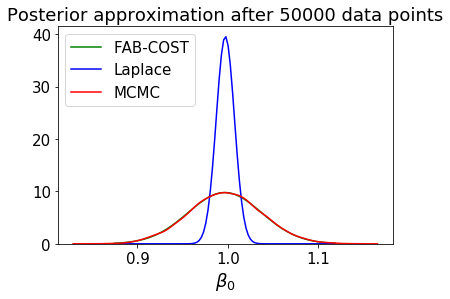

In [15]:
# posterior plot of beta_0
x = np.linspace(m_global[0] - 3*V_global[0,0]**0.5, m_global[0] + 3*V_global[0,0]**0.5, 100)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)
plt.xlabel(r'$\beta_0$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_second, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[0], V_global[0,0]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[0], 1/H_laplace[0,0]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,0], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()

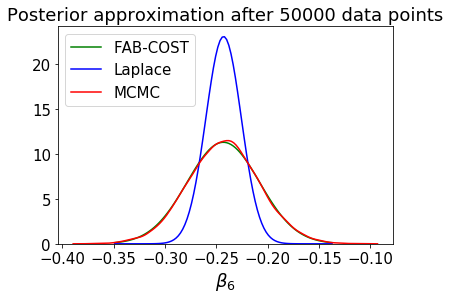

In [16]:
# posterior plot of beta_6
x = np.linspace(m_global[5] - 3*V_global[5,5]**0.5, m_global[5] + 3*V_global[5,5]**0.5, 100)
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=15) 
plt.xlabel(r'$\beta_6$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_second, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[5], V_global[5,5]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[5], 1/H_laplace[5,5]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,5], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [ ]:
# PYMC3
with pm.Model() as logistic_model:
    # Define priors
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = d)
       
    logit_p = t.dot(X[0:n_third,:], beta)
    pm.Bernoulli('likelihood', logit_p=logit_p, observed=y[0:n_third])
    
    
with logistic_model:
    # Inference
    trace = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains:  75%|███████▌  | 7500/10000 [12:51<08:49,  4.72draws/s] 

In [ ]:
axes = pm.traceplot(trace)

In [ ]:
# Assumed Density Filtering 

for i in range(n_second,n_third): # begins from last plot
    
    # for each iteration i, a cavity distribtuion is formed. 
    Vmi = V_global
    mmi = m_global
            
    k = 1/np.sqrt(1+ ((np.pi/8)*np.inner(X[i,:].dot(Vmi),X[i,:]))) # Mackay's approximation constant
    zz = y2[i]*(np.transpose(X[i,:]).dot(mmi))*k 
    Z = sigmoid(zz) # logistic function
    d_Z = d_sigmoid(zz) # derivative of logistic function

    alpha_ep = y2[i]*k*(d_sigmoid(zz)/sigmoid(zz))*(X[i,:][np.newaxis, :].T) # log-partition diff wrt mmi
    beta_ep = (-np.pi*k**2/16)*np.outer(X[i,:],X[i,:]).dot(np.outer(mmi,alpha_ep)) # log-partition diff wrt vmi
                             
    m_global = mmi + Vmi.dot(alpha_ep)# update of mean for approximating distribution q
    V_global = Vmi - Vmi.dot((np.outer(alpha_ep,alpha_ep) - 2*beta_ep)).dot(Vmi) # update of variance for approimating distribution q    
    

In [ ]:

H = np.ones(d)*(1/10**2) # initialises Hessian (precision matrix) as identity (for Laplace)
H = np.diag((H)) # initialises Hessian as identity (for Laplace)
wprior = np.zeros((d)) # initialises prior vector

w_laplace, H_laplace = fit_bayes_logistic(y[0:n_third], X[0:n_third,:], wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=1000)# Laplace inference


In [ ]:
# posterior plot of beta_0
x = np.linspace(m_global[0] - 3*V_global[0,0]**0.5, m_global[0] + 3*V_global[0,0]**0.5, 100)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)
plt.xlabel(r'$\beta_0$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_third, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[0], V_global[0,0]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[0], 1/H_laplace[0,0]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,0], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [ ]:
# posterior plot of beta_6
x = np.linspace(m_global[5] - 3*V_global[5,5]**0.5, m_global[5] + 3*V_global[5,5]**0.5, 100)
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=15) 
plt.xlabel(r'$\beta_6$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_third, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[5], V_global[5,5]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[5], 1/H_laplace[5,5]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,5], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [ ]:
# PYMC3

with pm.Model() as logistic_model:
    # Define priors
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = d)
       
    logit_p = t.dot(X[0:n_fourth,:], beta)
    pm.Bernoulli('likelihood', logit_p=logit_p, observed=y[0:n_fourth])
    
    
with logistic_model:
    # Inference
    trace = pm.sample(2000)


In [ ]:
axes = pm.traceplot(trace)

In [ ]:
# Assumed Density Filtering 

for i in range(n_third,n_fourth): # begins from last plot
    
    # for each iteration i, a cavity distribtuion is formed. 
    Vmi = V_global
    mmi = m_global
            
    k = 1/np.sqrt(1+ ((np.pi/8)*np.inner(X[i,:].dot(Vmi),X[i,:]))) # Mackay's approximation constant
    zz = y2[i]*(np.transpose(X[i,:]).dot(mmi))*k 
    Z = sigmoid(zz) # logistic function
    d_Z = d_sigmoid(zz) # derivative of logistic function

    alpha_ep = y2[i]*k*(d_sigmoid(zz)/sigmoid(zz))*(X[i,:][np.newaxis, :].T) # log-partition diff wrt mmi
    beta_ep = (-np.pi*k**2/16)*np.outer(X[i,:],X[i,:]).dot(np.outer(mmi,alpha_ep)) # log-partition diff wrt vmi
                             
    m_global = mmi + Vmi.dot(alpha_ep)# update of mean for approximating distribution q
    V_global = Vmi - Vmi.dot((np.outer(alpha_ep,alpha_ep) - 2*beta_ep)).dot(Vmi) # update of variance for approimating distribution q    
    

In [ ]:

H = np.ones(d)*(1/10**2) # initialises Hessian (precision matrix) as identity (for Laplace)
H = np.diag((H)) # initialises Hessian as identity (for Laplace)
wprior = np.zeros((d)) # initialises prior vector

w_laplace, H_laplace = fit_bayes_logistic(y[0:n_fourth], X[0:n_fourth,:], wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=1000)# Laplace inference


In [ ]:
# posterior plot of beta_0
x = np.linspace(m_global[0] - 3*V_global[0,0]**0.5, m_global[0] + 3*V_global[0,0]**0.5, 100)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)
plt.xlabel(r'$\beta_0$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_forth, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[0], V_global[0,0]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[0], 1/H_laplace[0,0]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,0], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [ ]:
# posterior plot of beta_6
x = np.linspace(m_global[5] - 3*V_global[5,5]**0.5, m_global[5] + 3*V_global[5,5]**0.5, 100)
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=15) 
plt.xlabel(r'$\beta_6$', fontsize=18)
plt.title(r'Posterior approximation after %i data points'%n_fourth, fontsize=18)
plt.plot(x,sp.stats.norm.pdf(x, m_global[5], V_global[5,5]**0.5),color='green', label = 'FAB-COST')
plt.plot(x,sp.stats.norm.pdf(x, w_laplace[5], 1/H_laplace[5,5]**0.5),color='blue', label = 'Laplace')
sns.kdeplot(trace['beta'][:,5], shade=False, color="r", label = 'MCMC')
plt.legend(loc=2, prop={'size': 15})
plt.show()